In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('marketing_campaign_data.csv')
pd.set_option('display.max_columns', None)
df.sample(5)

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Age_Group,Gen_Group,DaysAsCustomer,NumChildren,NumAcceptedCmp,Total_Purchases,Total_Spending,Conversion_Rate
657,S3,Menikah,59304000.0,0,1,2013-07-29,81,418000,61000,428000,80000,51000,10000,3,7,8,10,5,0,0,0,0,0,0,0,58,Senior,Boomers,3350,1,0,28,1048000,0.0
959,D3,Menikah,15716000.0,1,0,2012-11-12,8,16000,5000,30000,8000,7000,26000,3,3,0,4,8,0,0,0,0,0,1,0,34,Adult,Millennials,3609,1,0,10,92000,0.0
1410,S3,Menikah,43269000.0,1,0,2013-09-16,61,10000,1000,7000,0,0,1000,1,1,0,2,8,0,0,0,0,0,0,0,50,Mature,Gen X,3301,1,0,4,19000,0.0
819,S3,Bertunangan,56575000.0,0,2,2013-05-05,42,421000,5000,90000,0,16000,10000,3,7,3,7,5,0,0,0,0,0,0,0,55,Senior,Gen X,3435,2,0,20,542000,0.0
67,S3,Menikah,60631000.0,1,1,2013-04-05,88,565000,6000,65000,0,6000,19000,5,9,2,8,7,0,1,0,0,0,0,0,47,Mature,Gen X,3465,2,1,24,661000,0.1


In [4]:
df.shape

(2216, 34)

## DATA PREPROCESSING

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Marital_Status       2216 non-null   object 
 2   Income               2216 non-null   float64
 3   Kidhome              2216 non-null   int64  
 4   Teenhome             2216 non-null   int64  
 5   Dt_Customer          2216 non-null   object 
 6   Recency              2216 non-null   int64  
 7   MntCoke              2216 non-null   int64  
 8   MntFruits            2216 non-null   int64  
 9   MntMeatProducts      2216 non-null   int64  
 10  MntFishProducts      2216 non-null   int64  
 11  MntSweetProducts     2216 non-null   int64  
 12  MntGoldProds         2216 non-null   int64  
 13  NumDealsPurchases    2216 non-null   int64  
 14  NumWebPurchases      2216 non-null   int64  
 15  NumCatalogPurchases  2216 non-null   i

## Handle duplicated data

In [6]:
df.duplicated().sum()

np.int64(183)

In [7]:
df.drop_duplicates(keep='first', inplace=True)
df.shape

(2033, 34)

### Drop Unnecessary Features

In [8]:
df.drop(['Kidhome', 'Teenhome',
       'Dt_Customer', 'MntCoke', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Response'], axis=1, inplace=True)

## Future Selection 

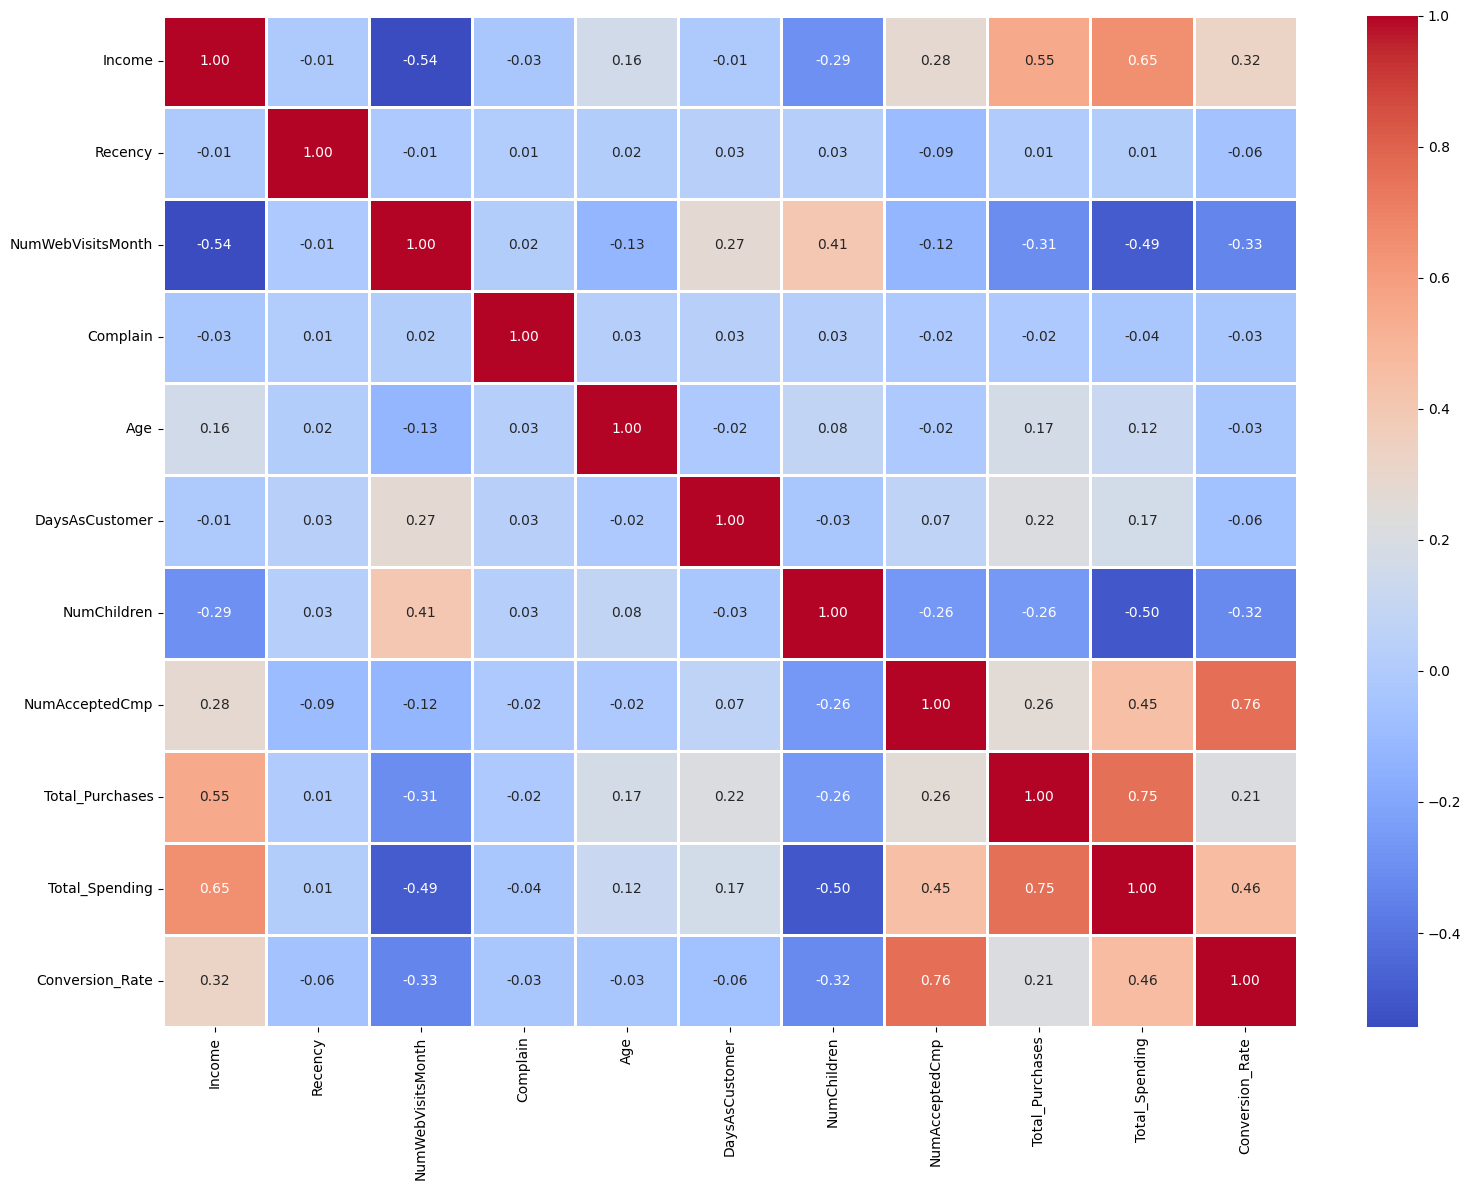

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = df.select_dtypes(include=['number'])

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(16, 12))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=1, cmap='coolwarm')

plt.tight_layout()

plt.show()


We're going to use features which are highly correlated to conversion rate as features in clustering:
1. Total_Purchases (Frequency)
2. Total_Spending (Monetary)
3. NumAcceptedCmp (Campaign)

### Handle Outliers

In [13]:
df['F'] = df['Total_Purchases']
df['M'] = df['Total_Spending']
df['C'] = df['NumAcceptedCmp']

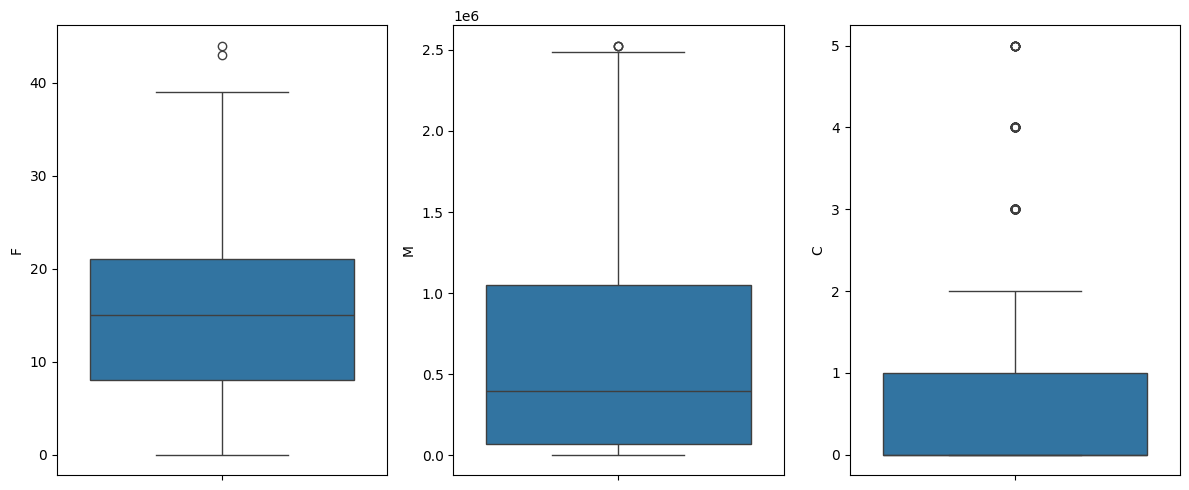

In [14]:
cols = ['F', 'M', 'C']
plt.figure(figsize=(12, 5))
for i in range(len(cols)):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[cols[i]])
    plt.tight_layout()

In [15]:
for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low_lim = q1 - 1.5*iqr
    up_lim = q3 + 1.5*iqr
    outlier = []
    for x in df[col]:
        if ((x > up_lim) or (x < low_lim)):
            outlier.append(x)
    if len(outlier) != 0 :
        print(f"{col} column has outliers outside lower limit {low_lim} and upper limit {up_lim}")
        print(f"Outliers in {col} column are {len(outlier)}\n")

F column has outliers outside lower limit -11.5 and upper limit 40.5
Outliers in F column are 2

M column has outliers outside lower limit -1399500.0 and upper limit 2516500.0
Outliers in M column are 3

C column has outliers outside lower limit -1.5 and upper limit 2.5
Outliers in C column are 89



In [16]:
df.loc[df['F'] > 40, 'F'] = 40
df.loc[df['M'] > 2516500, 'M'] = 2516500
df.loc[df['C'] > 2, 'C'] = 2

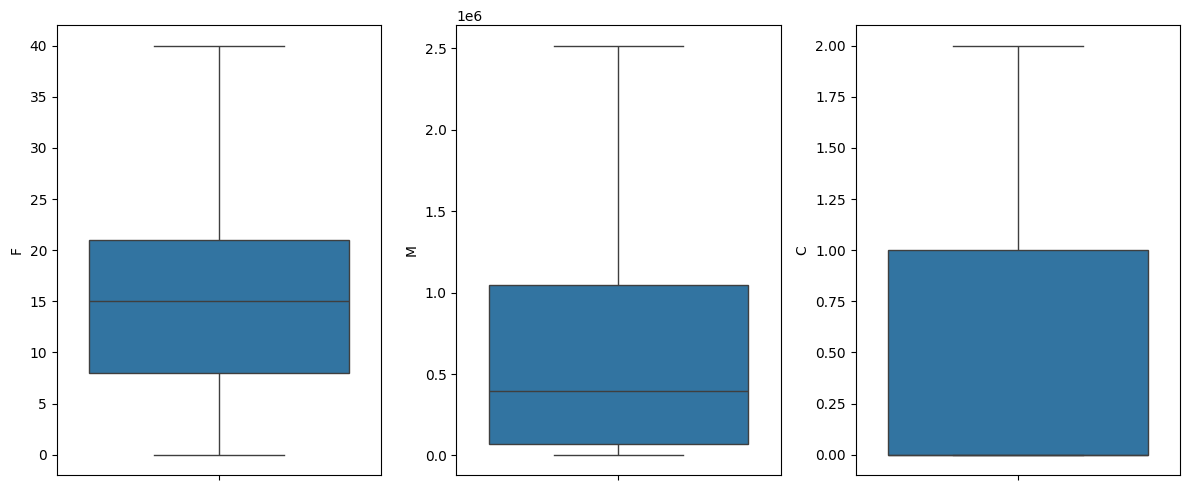

In [17]:
plt.figure(figsize=(12, 5))
for i in range(len(cols)):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[cols[i]])
    plt.tight_layout()

## Feature Transformation

In [18]:
df_scaled = df.filter(['F', 'M', 'C'])

In [19]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled, columns=['F', 'M', 'C'])
df_scaled.head()

,F,M,C
0,0.625,0.641848,0.5
1,0.150,0.008760,0.0
2,0.525,0.306988,0.0
3,0.200,0.019112,0.0
4,0.475,0.166036,0.0


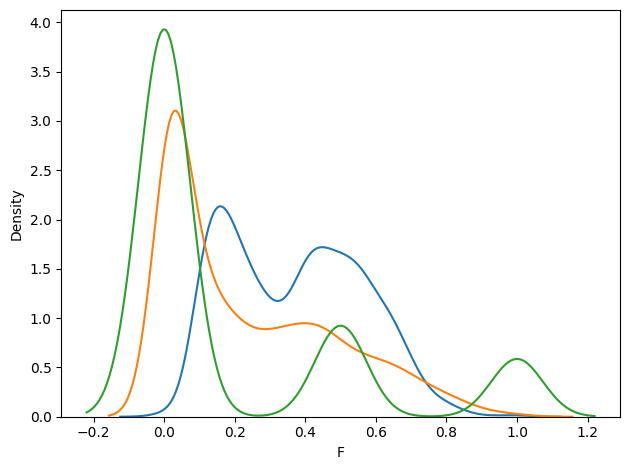

In [20]:
sns.kdeplot(df_scaled['F'])
sns.kdeplot(df_scaled['M'])
sns.kdeplot(df_scaled['C'])
plt.tight_layout()

In [21]:
df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
F,2033.0,0.372110,0.191142,0.0,0.200000,0.375000,0.52500,1.0
M,2033.0,0.239982,0.240354,0.0,0.025483,0.156082,0.41529,1.0
C,2033.0,0.192573,0.336332,0.0,0.000000,0.000000,0.50000,1.0


## Modeling

<Axes: title={'center': 'Inertia Evaluation Score'}>

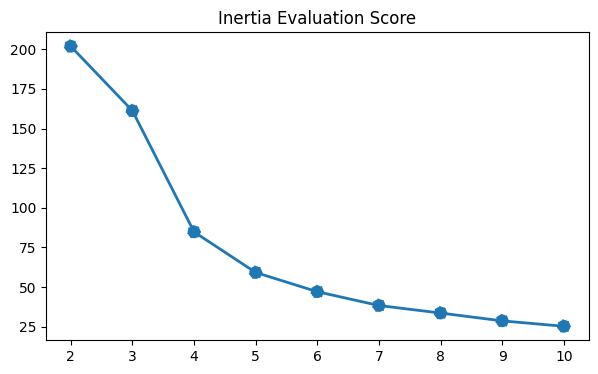

In [22]:
inertia = []
 
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)#, random_state=0)
    kmeans.fit(df_scaled.values)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,4))
plt.title('Inertia Evaluation Score', fontsize=12)
sns.lineplot(x=range(2, 11), y=inertia, linewidth = 2)
sns.scatterplot(x=range(2, 11), y=inertia, s=100, linestyle='--')

In [23]:
(pd.Series(inertia) - pd.Series(inertia).shift(-1)) / pd.Series(inertia) * 100

0    20.150408
1    47.441252
2    30.233820
3    20.542120
4    18.523077
5    12.427037
6    14.737010
7    11.923211
8          NaN
dtype: float64

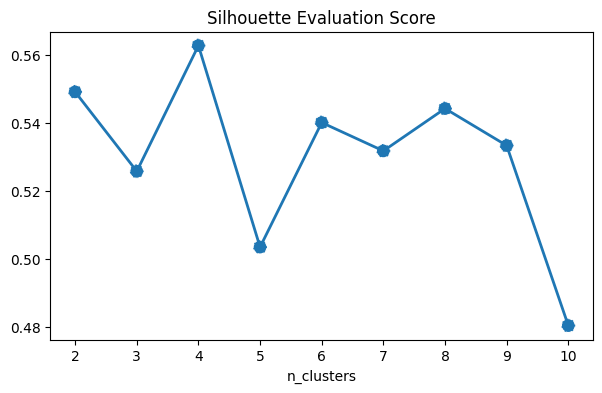

In [24]:
range_n_clusters = list(range(2,11))
arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(df_scaled)
    preds = kmeans.predict(df_scaled)
    score_euclidean = silhouette_score(df_scaled, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

fig, ax = plt.subplots(figsize=(7, 4))
plt.title('Silhouette Evaluation Score', fontsize=12)
sns.lineplot(x=range(2,11), y=arr_silhouette_score_euclidean,  linewidth = 2)
sns.scatterplot(x=range(2,11), y=arr_silhouette_score_euclidean, s=100, linestyle='--')
plt.xlabel('n_clusters')
plt.show()

In [25]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(df_scaled)
df_scaled['cluster'] = kmeans.labels_

df_cluster = df.filter(['Total_Purchases','Total_Spending','NumAcceptedCmp'])
df_cluster.columns = ['F', 'M', 'C']
df_cluster['cluster'] = kmeans.labels_

In [26]:
pca = PCA(n_components=2)

pca.fit(df_scaled)
pcs = pca.transform(df_scaled)

df_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
df_pca['cluster'] = df_scaled['cluster']
df_pca.sample(10)

,PC 1,PC 2,cluster
1454,-0.319359,-0.363192,1
2026,-1.273072,0.382042,0
316,1.865934,-0.228021,3
1864,1.746275,-0.190615,3
1184,0.786030,0.300937,2
86,0.780932,0.121272,2
156,-1.271800,0.231513,0
705,-1.272436,0.439494,0
170,-0.318712,-0.320256,1
888,-0.317897,-0.288583,1


<Axes: title={'center': '2-D Visualization of Customer Clusters\nWih PCA'}, xlabel='PC 2', ylabel='PC 1'>

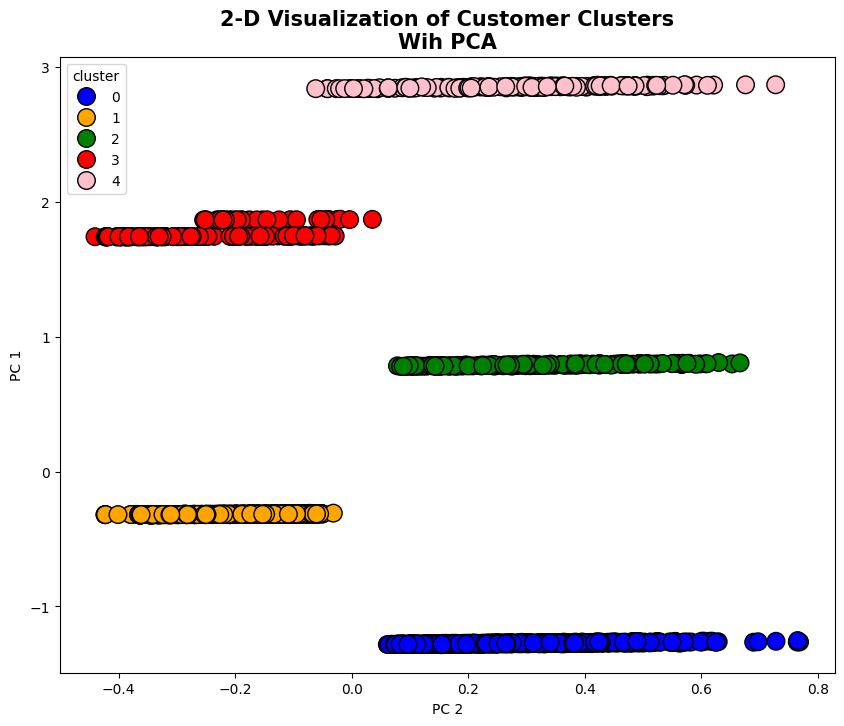

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title("2-D Visualization of Customer Clusters\nWih PCA", fontsize=15, weight='bold')
sns.scatterplot(y="PC 1", 
                x="PC 2",
                hue="cluster",
                edgecolor='black',
                data=df_pca,
                palette=['blue','orange','green','red','pink'],
                s=160,
                ax=ax)